In [1]:
##############################################################
# BG-NBD ve Gamma-Gamma ile CLTV Prediction
##############################################################

# 1. Verinin Hazırlanması (Data Preperation)
# 2. BG-NBD Modeli ile Expected Number of Transaction
# 3. Gamma-Gamma Modeli ile Expected Average Profit
# 4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
# 6. Çalışmanın fonksiyonlaştırılması


##############################################################
# 1. Verinin Hazırlanması (Data Preperation)
##############################################################

# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
# pazarlama stratejileri belirlemek istiyor.

# Veri Seti Hikayesi

# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler

# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.

In [2]:
##########################
# Gerekli Kütüphane ve Fonksiyonlar
##########################

!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler


def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [3]:
df_ = pd.read_excel("C:/Users/Erdem Yavuz/Desktop/PYTHON/CRM_Analytics/online_retail_II.xlsx",sheet_name="Year 2010-2011")

In [4]:
df = df_.copy()
df.describe().T
df.head()
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [ ]:
#########################
# Veri Ön İşleme
#########################

In [5]:
df.dropna(inplace = True)

In [6]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
df = df[~df["Invoice"].str.contains('C',na = False)]

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0000,13.0218,180.4200,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397925.0000,3.1162,22.0968,0.0000,1.2500,1.9500,3.7500,8142.7500
Customer ID,397925.0000,15294.3086,1713.1727,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [10]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0 ]

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,12.9882,179.3316,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397885.0000,3.1165,22.0979,0.0010,1.2500,1.9500,3.7500,8142.7500
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [13]:
replace_with_thresholds(df,"Quantity")

In [14]:
replace_with_thresholds(df,"Price")

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,2.8935,3.2272,0.0010,1.2500,1.9500,3.7500,37.0600
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [16]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,2.8935,3.2272,0.0010,1.2500,1.9500,3.7500,37.0600
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000
TotalPrice,397885.0000,20.6298,51.8285,0.0010,4.6800,11.8000,19.8000,3268.5750


In [18]:
today_date = dt.datetime(2011, 12, 11)

In [19]:
#########################
# Lifetime Veri Yapısının Hazırlanması
#########################

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç

In [20]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [27]:
cltv_df = df.groupby("Customer ID").agg({'InvoiceDate' : [lambda date : (date.max() - date.min()).days,
                                                          lambda date : (today_date - date.min()).days],
                                         'Invoice' : lambda num : num.nunique(),
                                         'TotalPrice' : lambda TotalPrice : TotalPrice.sum()})

In [28]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        326        1   310.4400
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1770.7800
12349.0000            0         19        1  1491.7200
12350.0000            0        311        1   331.4600

In [30]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [42]:
cltv_df.columns = ['recency','T','frequency','monetary']

In [33]:
cltv_df.head()

,receny,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [34]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [35]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
receny,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [36]:
cltv_df = cltv_df[cltv_df["frequency"] > 1]

In [39]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
receny,2845.0000,198.9054,113.8670,0.0000,98.0000,207.0000,299.0000,373.0000
T,2845.0000,258.7842,102.9909,3.0000,192.0000,283.0000,359.0000,374.0000
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


In [43]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [44]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,28.4151,16.2667,0.0000,14.0000,29.5714,42.7143,53.2857
T,2845.0000,36.9692,14.7130,0.4286,27.4286,40.4286,51.2857,53.4286
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


In [45]:
##############################################################
# 2.BG-NBD Modelinin Kurulması
##############################################################

In [47]:
bgf = BetaGeoFitter(penalizer_coef = 0.001)
bgf.fit(cltv_df["frequency"],
       cltv_df["recency"],
       cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [53]:
################################################################
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df["frequency"],
                                                        cltv_df["recency"],
                                                        cltv_df["T"]).sort_values(ascending = False).head(10)
                                                        

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [54]:
bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sort_values(ascending = False).head(10)

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [56]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [57]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223


In [58]:
bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sort_values(ascending = False).head(10)

Customer ID
12748.0000   12.9633
14911.0000   12.4722
17841.0000    7.7398
13089.0000    6.1330
14606.0000    5.8399
15311.0000    5.7191
12971.0000    5.4131
14646.0000    4.8119
13408.0000    3.9341
18102.0000    3.8636
dtype: float64

In [59]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [60]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862


In [62]:
################################################################
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################
cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3 ,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [67]:
bgf.predict(4 * 3 ,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sum()

5271.112433826376

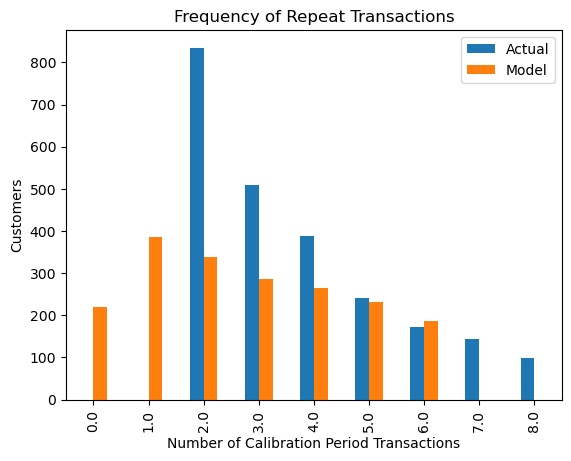

In [68]:
################################################################
# Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()

In [69]:
##############################################################
# 3. GAMMA-GAMMA Modelinin Kurulması
##############################################################

In [70]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [71]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [72]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

Customer ID
12347.0000    631.9123
12348.0000    463.7460
12352.0000    224.8868
12356.0000    995.9989
12358.0000    631.9022
12359.0000   1435.0385
12360.0000    933.7905
12362.0000    532.2318
12363.0000    304.2643
12364.0000    344.1370
dtype: float64

In [73]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
18102.0000   3870.9969
12753.0000   3678.5783
14646.0000   3654.8148
15749.0000   3216.0523
14096.0000   3196.4361
dtype: float64

In [75]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [76]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,total_purc_3_month,expected_average_profit
Customer ID,,,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5271.1124,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0460,0.1363,5271.1124,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,0.9035,5271.1124,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,1.3854,5271.1124,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0379,3.0896,5271.1124,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,5271.1124,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,1.4973,5271.1124,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,5271.1124,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,0.3320,5271.1124,3216.0523


In [77]:
##############################################################
# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
##############################################################

In [78]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [79]:
cltv.head()

Customer ID
12347.0000   1128.4477
12348.0000    538.8089
12352.0000    517.5000
12356.0000   1083.0903
12358.0000    966.6727
Name: clv, dtype: float64

In [80]:
cltv = cltv.reset_index()

In [81]:
cltv_final = cltv_df.merge(cltv,on = "Customer ID", how = "left")

In [86]:
cltv_final.sort_values(by = "clv", ascending = False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,total_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,5271.1124,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,5271.1124,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,5271.1124,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5271.1124,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,5271.1124,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,5271.1124,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,5271.1124,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,5271.1124,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,5271.1124,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,5271.1124,1280.2183,12966.1347


In [87]:

##############################################################
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
##############################################################

In [96]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels= ["D","C","B","A"])
cltv_final.sort_values(by = "clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,total_purc_3_month,expected_average_profit,clv,segment
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,5271.1124,3654.8148,55741.0845,A
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,5271.1124,3870.9969,47412.5801,A
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,5271.1124,3196.4361,29061.6614,A
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5271.1124,5772.1782,27685.1000,A
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,5271.1124,692.3264,27377.4115,A
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,5271.1124,2874.1987,27166.0643,A
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,5271.1124,2110.7542,23424.4032,A
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,5271.1124,2950.5801,18986.6123,A
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,5271.1124,2223.8850,13440.4131,A
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,5271.1124,1280.2183,12966.1347,A


In [93]:
cltv_final.groupby("segment").agg({"count","mean","sum"})

Customer ID                          recency                        T                    frequency               monetary                      expected_purc_1_week                 expected_purc_1_month                 expected_purc_3_month                  total_purc_3_month                        expected_average_profit                        clv                       
              count           sum       mean   count        sum    mean count        sum    mean     count   sum    mean    count         sum     mean                count      sum   mean                 count      sum   mean                 count       sum   mean              count          sum      mean                   count         sum     mean count          sum      mean
segment                                                                                                                                                                                                                                                                                                                                                                                     
D               712 11077635.0000 15558.4761     712 15716.5714 22.0738   712 28811.0000 40.4649       712  2182  3.0646      712 130981.7123 183.9631                  712  50.5898 0.0711                   712 201.4774 0.2830                   712  598.0905 0.8400                712 3753032.0529 5271.1124                     712 141999.6650 199.4377   712  102027.4901  143.2970
C               711 10885150.0000 15309.6343     711 21806.1429 30.6697   711 27097.0000 38.1111       711  2912  4.0956      711 193174.9847 271.6948                  711  85.7309 0.1206                   711 341.3936 0.4802                   711 1013.2176 1.4251                711 3747760.9405 5271.1124                     711 206179.7461 289.9856   711  270743.0065  380.7919
B               711 10915854.0000 15352.8186     711 20985.0000 29.5148   711 24751.1429 34.8117       711  3869  5.4416      711 265517.6312 373.4425                  711 115.5066 0.1625                   711 459.6926 0.6465                   711 1362.6595 1.9165                711 3747760.9405 5271.1124                     711 280058.9431 393.8944   711  489356.3925  688.2650
A               711 10627572.0000 14947.3586     711 22333.1429 31.4109   711 24518.1429 34.4840       711  8076 11.3586      711 469159.4581 659.8586                  711 194.4993 0.2736                   711 774.3298 1.0891                   711 2297.1448 3.2309                711 3747760.9405 5271.1124                     711 487674.7239 685.8998   711 1580097.9284 2222.3600

In [97]:
##############################################################
# 6. Çalışmanın Fonksiyonlaştırılması
##############################################################

In [98]:
def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final

In [99]:
df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")